In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: True


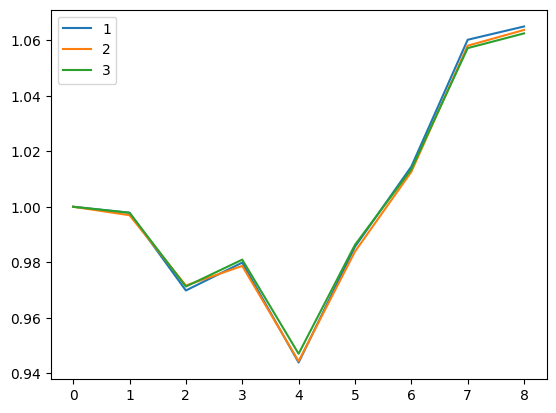

In [3]:
N_NEEDED = 9

perf1 = np.array([103273])
perf2 = np.array([102405])
perf3 = np.array([102642])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [ 22701, 21595, 30275]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [5]:
BEST = 1  # [1, 2, 3]
MUTATE_SCALE = 0.49005  # x0.9 or x1.1 decrease if same; incr if new

In [6]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,87.940002,1,0.657074,0.342926,0.966614,0.061455,0.662917
1,AAPL,209.279999,1,0.424860,0.575140,0.901431,0.222826,0.814791
2,ABNB,122.510002,1,0.641144,0.358856,0.829690,0.328542,0.168241
3,ACN,293.390015,1,0.248201,0.751799,0.366455,0.045987,0.644636
4,ADBE,367.720001,1,0.350520,0.649480,0.580684,0.055184,0.636617


In [7]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [8]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [9]:
len(states)

3

In [10]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [11]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

mutating...


In [12]:
len(mods)

3

In [13]:
#for mod in mods:
#    print(mod.Ws)

In [14]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [15]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,967.34,1055.28,967.34
AAPL,837.12,627.84,837.12
ABBV,558.18,558.18,744.24
ABNB,735.06,1225.10,0.00
ABT,515.40,0.00,0.00


In [16]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,87.94,0.004889,0.002216,0.005608
1,AAPL,209.28,0.006500,0.003266,0.005932
2,ABNB,122.51,0.003132,0.004281,0.005561
3,ACN,293.39,0.007492,0.007957,0.006597
4,ADBE,367.72,0.006996,0.005759,0.006304


In [17]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[206546.09000000003, 204810.33, 205284.02000000002]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,87.94,0.004889,0.002216,0.005608,1009.86,453.86,1151.24
AAPL,209.28,0.006500,0.003266,0.005932,1342.52,668.98,1217.67
ABNB,122.51,0.003132,0.004281,0.005561,646.98,876.71,1141.49
ACN,293.39,0.007492,0.007957,0.006597,1547.48,1629.72,1354.29
ADBE,367.72,0.006996,0.005759,0.006304,1444.94,1179.43,1294.05


In [18]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,87.94,0.004889,0.002216,0.005608,1009.86,453.86,1151.24,967.34,1055.28,967.34
AAPL,209.28,0.006500,0.003266,0.005932,1342.52,668.98,1217.67,837.12,627.84,837.12
ABNB,122.51,0.003132,0.004281,0.005561,646.98,876.71,1141.49,735.06,1225.10,0.00
ACN,293.39,0.007492,0.007957,0.006597,1547.48,1629.72,1354.29,880.17,880.17,880.17
ADBE,367.72,0.006996,0.005759,0.006304,1444.94,1179.43,1294.05,1103.16,367.72,1103.16


In [19]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,87.94,0.004889,0.002216,0.005608,1009.86,453.86,1151.24,967.34,1055.28,967.34,42.52,-601.42,183.90
AAPL,209.28,0.006500,0.003266,0.005932,1342.52,668.98,1217.67,837.12,627.84,837.12,505.40,41.14,380.55
ABNB,122.51,0.003132,0.004281,0.005561,646.98,876.71,1141.49,735.06,1225.10,0.00,-88.08,-348.39,1141.49
ACN,293.39,0.007492,0.007957,0.006597,1547.48,1629.72,1354.29,880.17,880.17,880.17,667.31,749.55,474.12
ADBE,367.72,0.006996,0.005759,0.006304,1444.94,1179.43,1294.05,1103.16,367.72,1103.16,341.78,811.71,190.89


In [20]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [21]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,87.94,0.004889,0.002216,0.005608,1009.86,453.86,1151.24,967.34,1055.28,967.34,42.52,-601.42,183.90,0,-7,2
AAPL,209.28,0.006500,0.003266,0.005932,1342.52,668.98,1217.67,837.12,627.84,837.12,505.40,41.14,380.55,2,0,2
ABNB,122.51,0.003132,0.004281,0.005561,646.98,876.71,1141.49,735.06,1225.10,0.00,-88.08,-348.39,1141.49,-1,-3,9
ACN,293.39,0.007492,0.007957,0.006597,1547.48,1629.72,1354.29,880.17,880.17,880.17,667.31,749.55,474.12,2,3,2
ADBE,367.72,0.006996,0.005759,0.006304,1444.94,1179.43,1294.05,1103.16,367.72,1103.16,341.78,811.71,190.89,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,8.13,0.001649,0.004279,0.004666,340.52,876.35,957.92,0.00,1203.24,0.00,340.52,-326.89,957.92,42,-40,118
WING,227.30,0.007485,0.006871,0.006630,1546.08,1407.19,1361.05,909.20,909.20,909.20,636.88,497.99,451.85,3,2,2
WIT,2.83,0.005774,0.007448,0.005891,1192.69,1525.33,1209.35,1024.46,1168.79,834.85,168.23,356.54,374.50,59,126,132


<span style="color: red">CHECK URL!</span>

In [22]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
UBSI,34.09,946.82,28
MA,533.48,927.63,2
RGTI,9.37,927.24,99
NVDA,111.01,918.21,8
V,335.17,909.47,3


In [23]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
MIY,11.25,-213.05,-19
PSTG,45.70,-232.25,-5
PTON,6.29,-255.53,-41
MCHP,46.89,-284.00,-6
CHTR,373.65,-726.56,-2


<span style="color: red">SERIOUSLY....</span></br>
<span style="color: red">CHECK URL!</span>

In [24]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
PGR,265.01,1950.38,7
KNSL,419.99,1828.72,4
CELH,36.74,1492.01,41
AMT,210.82,1394.16,7
CB,279.11,1382.28,5


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
IVV,553.19,-612.55,-1
ELF,61.15,-636.23,-10
MCHP,46.89,-637.87,-14
NLR,77.98,-746.61,-10
MELI,2225.85,-1181.26,-1


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
RDY,13.79,1221.90,89
RVLV,20.42,1219.06,60
U,22.45,1203.56,54
UBSI,34.09,1200.11,35
AEO,11.20,1165.09,104


In [28]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
QBTS,7.53,-88.45,-12
PSTG,45.70,-88.55,-2
CCI,100.19,-127.33,-1
MRK,82.74,-248.15,-3
CHTR,373.65,-355.22,-1


In [29]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

States saved
